# 4304 Project Infographic

In [239]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import pyfonts
from mpl_flags import Flags
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, AnnotationBbox, VPacker)

___________________

In [2]:
df = pd.read_csv('satcat.tsv', sep='\t', low_memory=False)[1:]

In [3]:
orgs = pd.read_csv("orgs.tsv", sep="\t", usecols=["#Code", "Class", "ShortName", "Name"]).drop(0)
orgs.rename(columns={"#Code": "Owner"}, inplace=True)

In [4]:
class_mapping = {
    "A": "Academic/Non-Profit",
    "B": "Business/Commercial",
    "C": "Civil Government",
    "D": "Defense/Military"
}

orbit_mapping = {
    'LEO': ['LEO/I', 'LLEO/I', 'LEO/P', 'LLEO/P', 'LEO/S', 'LEO/E', 'LEO/R', 'LLEO/R', 'LLEO/S', 'LLEO/E'],
    'MEO': ['MEO'],
    'GEO': ['GEO/NS', 'GEO/T', 'GEO/S', 'GEO/D', 'GEO/I', 'GEO/ID'],
    'GTO': ['GTO'],
    'HEO': ['HEO', 'VHEO', 'HEO/M'],
    'Deep Space': ['DSO', 'SO', 'CLO', 'TA'],
    'Unclassified': ['-']
}

def get_class_for_owner(owner):
    owners = owner.split("/")
    classes = orgs[orgs["Owner"].isin(owners)]["Class"].unique()
    
    return classes[0] if len(classes) > 0 else None
    
def map_orbit_type(oporbit):
    for category, types in orbit_mapping.items():
        if oporbit in types:
            return category
    return 'Other'

df['OrbitType'] = df['OpOrbit'].apply(map_orbit_type)
df["Class"] = df["Owner"].apply(get_class_for_owner)

In [5]:
df = df.merge(orgs[['Owner', 'ShortName', 'Name']], on='Owner', how='left')

In [6]:
df['State'] = df['State'].replace("SU", "RU")

In [7]:
df['ShortName'] = df['ShortName'].replace("SpaceX/Seattle", "SpaceX")
df['ShortName'] = df['ShortName'].replace("SpaceX Tourists", "SpaceX")
df['ShortName'] = df['ShortName'].replace("SpaceX/McGregor", "SpaceX")

In [309]:
font = pyfonts.load_font('https://github.com/google/fonts/blob/main/ofl/spacemono/SpaceMono-Regular.ttf?raw=true')
spacemono_bold = pyfonts.load_font('https://github.com/google/fonts/blob/main/ofl/spacemono/SpaceMono-Bold.ttf?raw=true')
lato = pyfonts.load_font('https://github.com/google/fonts/blob/main/ofl/lato/Lato-SemiBold.ttf?raw=true')
num_bold = pyfonts.load_font('https://github.com/google/fonts/blob/main/ofl/economica/Economica-Bold.ttf?raw=true')
chakra = pyfonts.load_font('https://github.com/google/fonts/blob/main/ofl/chakrapetch/ChakraPetch-Regular.ttf?raw=true')
chakra_bold = pyfonts.load_font('https://github.com/google/fonts/blob/main/ofl/chakrapetch/ChakraPetch-Bold.ttf?raw=true')
quan_bold = pyfonts.load_font('https://github.com/google/fonts/blob/main/ofl/quantico/Quantico-Bold.ttf?raw=true')

__________________________

## CurvedText class taken from StackOverflow (https://stackoverflow.com/a/44521963)

In [310]:
from matplotlib import patches
from matplotlib import text as mtext
import math

class CurvedText(mtext.Text):
    """
    A text object that follows an arbitrary curve.
    """
    def __init__(self, x, y, text, axes, **kwargs):
        super(CurvedText, self).__init__(x[0],y[0],' ', **kwargs)

        axes.add_artist(self)

        ##saving the curve:
        self.__x = x
        self.__y = y
        self.__zorder = self.get_zorder()

        ##creating the text objects
        self.__Characters = []
        for c in text:
            if c == ' ':
                ##make this an invisible 'a':
                t = mtext.Text(0,0,'a')
                t.set_alpha(0.0)
            else:
                t = mtext.Text(0,0,c, **kwargs)

            #resetting unnecessary arguments
            t.set_ha('center')
            t.set_rotation(0)
            t.set_zorder(self.__zorder +1)

            self.__Characters.append((c,t))
            axes.add_artist(t)


    ##overloading some member functions, to assure correct functionality
    ##on update
    def set_zorder(self, zorder):
        super(CurvedText, self).set_zorder(zorder)
        self.__zorder = self.get_zorder()
        for c,t in self.__Characters:
            t.set_zorder(self.__zorder+1)

    def draw(self, renderer, *args, **kwargs):
        """
        Overload of the Text.draw() function. Do not do
        do any drawing, but update the positions and rotation
        angles of self.__Characters.
        """
        self.update_positions(renderer)

    def update_positions(self,renderer):
        """
        Update positions and rotations of the individual text elements.
        """

        #preparations

        ##determining the aspect ratio:
        ##from https://stackoverflow.com/a/42014041/2454357

        ##data limits
        xlim = self.axes.get_xlim()
        ylim = self.axes.get_ylim()
        ## Axis size on figure
        figW, figH = self.axes.get_figure().get_size_inches()
        ## Ratio of display units
        _, _, w, h = self.axes.get_position().bounds
        ##final aspect ratio
        aspect = ((figW * w)/(figH * h))*(ylim[1]-ylim[0])/(xlim[1]-xlim[0])

        #points of the curve in figure coordinates:
        x_fig,y_fig = (
            np.array(l) for l in zip(*self.axes.transData.transform([
            (i,j) for i,j in zip(self.__x,self.__y)
            ]))
        )

        #point distances in figure coordinates
        x_fig_dist = (x_fig[1:]-x_fig[:-1])
        y_fig_dist = (y_fig[1:]-y_fig[:-1])
        r_fig_dist = np.sqrt(x_fig_dist**2+y_fig_dist**2)

        #arc length in figure coordinates
        l_fig = np.insert(np.cumsum(r_fig_dist),0,0)

        #angles in figure coordinates
        rads = np.arctan2((y_fig[1:] - y_fig[:-1]),(x_fig[1:] - x_fig[:-1]))
        degs = np.rad2deg(rads)


        rel_pos = 10
        for c,t in self.__Characters:
            #finding the width of c:
            t.set_rotation(0)
            t.set_va('center')
            bbox1  = t.get_window_extent(renderer=renderer)
            w = bbox1.width
            h = bbox1.height

            #ignore all letters that don't fit:
            if rel_pos+w/2 > l_fig[-1]:
                t.set_alpha(0.0)
                rel_pos += w
                continue

            elif c != ' ':
                t.set_alpha(1.0)

            #finding the two data points between which the horizontal
            #center point of the character will be situated
            #left and right indices:
            il = np.where(rel_pos+w/2 >= l_fig)[0][-1]
            ir = np.where(rel_pos+w/2 <= l_fig)[0][0]

            #if we exactly hit a data point:
            if ir == il:
                ir += 1

            #how much of the letter width was needed to find il:
            used = l_fig[il]-rel_pos
            rel_pos = l_fig[il]

            #relative distance between il and ir where the center
            #of the character will be
            fraction = (w/2-used)/r_fig_dist[il]

            ##setting the character position in data coordinates:
            ##interpolate between the two points:
            x = self.__x[il]+fraction*(self.__x[ir]-self.__x[il])
            y = self.__y[il]+fraction*(self.__y[ir]-self.__y[il])

            #getting the offset when setting correct vertical alignment
            #in data coordinates
            t.set_va(self.get_va())
            bbox2  = t.get_window_extent(renderer=renderer)

            bbox1d = self.axes.transData.inverted().transform(bbox1)
            bbox2d = self.axes.transData.inverted().transform(bbox2)
            dr = np.array(bbox2d[0]-bbox1d[0])

            #the rotation/stretch matrix
            rad = rads[il]
            rot_mat = np.array([
                [math.cos(rad), math.sin(rad)*aspect],
                [-math.sin(rad)/aspect, math.cos(rad)]
            ])

            ##computing the offset vector of the rotated character
            drp = np.dot(dr,rot_mat)

            #setting final position and rotation:
            t.set_position(np.array([x,y])+drp)
            t.set_rotation(degs[il])

            t.set_va('center')
            t.set_ha('center')

            #updating rel_pos to right edge of character
            rel_pos += w-used

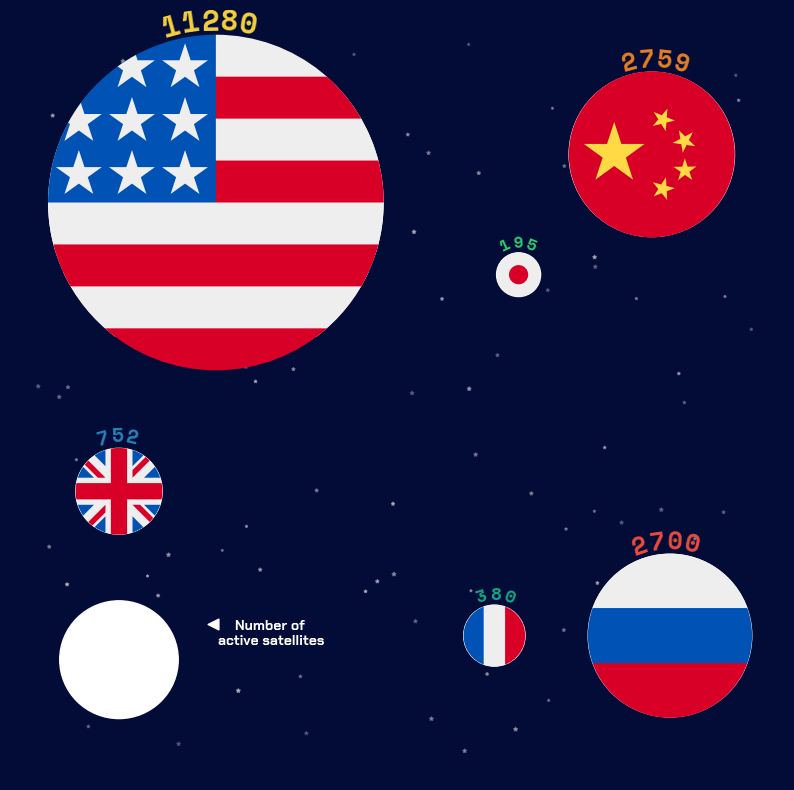

In [435]:
def get_circle_properties(country):
    count = top_10[country]
    radius = np.sqrt(count) * scale_factor
    return radius

def add_stars(ax, num_stars=100):
    np.random.seed(42)
    star_x = np.random.uniform(-15, 15, num_stars)
    star_y = np.random.uniform(-15, 15, num_stars)
    star_sizes = np.random.uniform(2, 8, num_stars)
    star_alpha = np.random.uniform(0.2, 0.5, num_stars)
    ax.scatter(star_x, star_y, s=star_sizes, c='white', alpha=star_alpha, marker='*')

payloads = df[df['Type'].str.contains('P', na=False) & df["Status"].isin(["O"])]
payload_counts = payloads.State.value_counts()
top_10 = payload_counts.head(10).to_dict()
other_count = payload_counts.iloc[5:].sum()
top_10["Other"] = other_count

positions = {
    "US": (-7.5, 8),
    "CN": (10.5, 10),
    "RU": (11.25, -10),
    "Other": (-11.5, -11),
    "UK": (-11.5, -4),
    "F": (4, -10),
    "J": (5, 5),
}

colors = {
    "US": "#F4D03F",
    "CN": "#E67E22",
    "RU": "#E74C3C",
    "Other": "#9ca3a3",
    "UK": "#2980B9",
    "F": "#16A085",
    "J": "#2ECC71",
}

font_sizes = {
    "US": 21,
    "CN": 18,
    "RU": 18,
    "Other": 16,
    "UK": 14,
    "F": 13,
    "J": 11.5,
}

text_adjustments = {
    "US": 1.0,
    "CN": 1.0,
    "RU": 1.0,
    "Other": 1.0,
    "UK": 1.05,
    "F": 1.05,
    "J": 1.1,
}

labels = {
    "US": "U.S.A.",
    "CN": "China",
    "RU": "Russia",
    "Other": "Other",
    "UK": "U.K.",
    "F": "France",
    "J": "Japan",
}

scale_factor = 0.065

fig, ax = plt.subplots(figsize=(10, 10))

ax.set_xlim(-16, 16)
ax.set_ylim(-16, 16)
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

fig.patch.set_facecolor('#030c36')
ax.set_facecolor('#030c36')

add_stars(ax)

flags = Flags("circle")

for country, (x, y) in positions.items():
    radius = get_circle_properties(country)
    
    # Create white circular background (same as before)
    circle = patches.Circle((x, y), radius,
                            color='#C0C6D1' if country == 'Other' else 'white',
                            alpha=1)
    ax.add_patch(circle)
    
    # Add the country flag
    if country == "UK":  # Special case for United Kingdom
        country_code = "GB"
    elif country == "F":
        country_code = "FR"
    elif country == "J":
        country_code = "JP"
    elif country == "Other":
        continue  # Skip flag for "Other" category
    else:
        country_code = country
    
    # Get flag drawing area and add it
    da = flags.get_drawing_area(country_code, wmax=radius*35)  # Scale flag size to match circle
    ab = AnnotationBbox(da, (x, y), frameon=False, box_alignment=(0.5, 0.5))
    ax.add_artist(ab)
    
    # Keep all the existing text and curved text code
    if country == "F" or country == "J":
        theta = np.linspace(3 * np.pi / 2, 3 * np.pi / 2 + 2 * np.pi, 100)
    else:
        theta = np.linspace(0, 2 * np.pi, 100)
    
    #if country in ["US", "CN"]:
    #    text_x = x - (radius * text_adjustments[country]) * np.cos(theta)
    #    text_y = y - (radius * text_adjustments[country]) * np.sin(theta)
    #else:
    #    text_x = x + (radius * text_adjustments[country]) * -np.cos(theta)
    #    text_y = y + (radius * text_adjustments[country]) * np.sin(theta)

    text_x = x + (radius * text_adjustments[country]) * -np.cos(theta)
    text_y = y + (radius * text_adjustments[country]) * np.sin(theta)
    
    font_color = colors[country]

    if country == 'US':
        padding = " " * 24
    elif country == 'CN':
        padding = " " * 11
    elif country == 'RU':
        padding = " " * 10
    elif country == 'F':
        padding = " " * 9
    elif country == 'J':
        padding = " " * 6
    else:
        padding = " " * 5
    
    CurvedText(
        x=text_x,
        y=text_y,
        text=padding + f"{top_10[country]}",
        va="bottom",
        axes=ax,
        fontsize=font_sizes[country],
        font=spacemono_bold,
        fontweight="bold",
        color=font_color
    )


#ax.text(-7.5, 7.65, "The U.S. has more active satellites than\n the rest of the world combined.", ha='center', font=chakra_bold, fontsize=12.5, alpha=0.9);
ax.scatter(-7.6, -9.5, marker='<', s=60, color='white')
ax.text(-5.2, -10.4, "Number of \nactive satellites", ha='center', color='white', weight='bold', font=chakra_bold, fontsize=10, alpha=1)
...;

,Launch_Year,State,Country
1,1957.0,RU,Russia
2,1957.0,RU,Russia
3,1958.0,US,United States
4,1958.0,US,United States
5,1958.0,US,United States
...,...,...,...
63384,2025.0,US,United States
63385,2025.0,US,United States
63386,2025.0,US,United States
63387,2025.0,US,United States


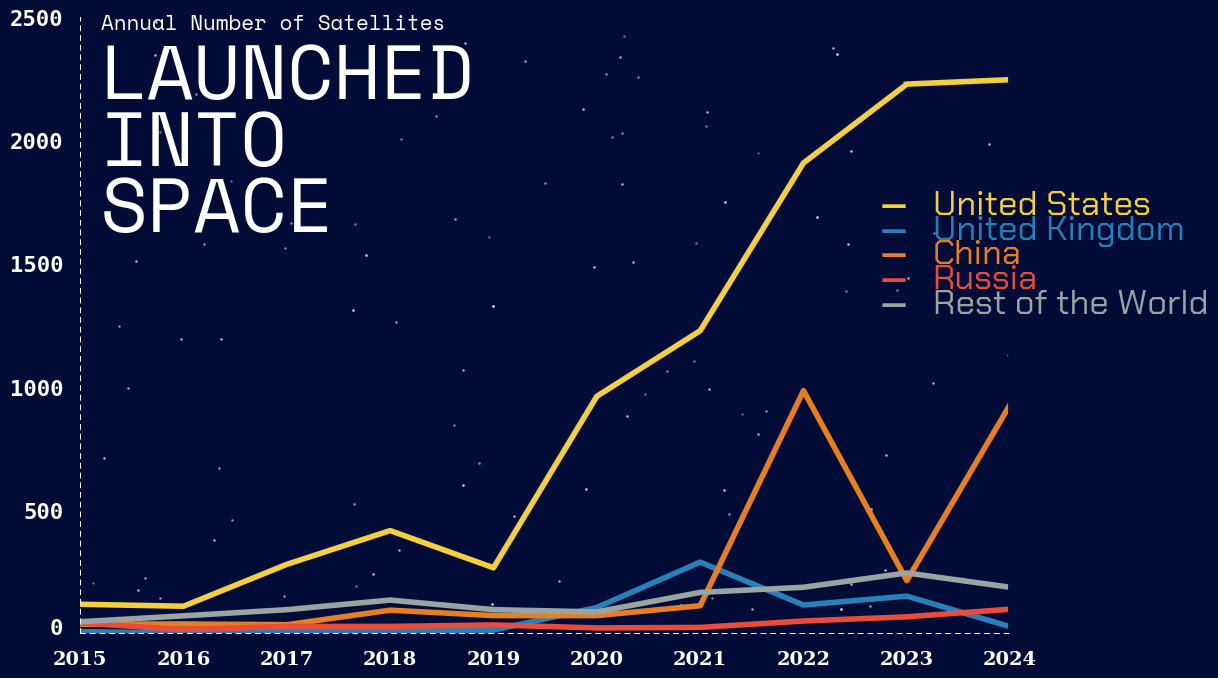

In [507]:
df_copy = df.copy()

df_copy["Launch_Year"] = pd.to_datetime(df_copy["LDate"], errors="coerce").dt.year
df_copy = df_copy[df_copy['Type'].str.contains('P', na=False)]
df_copy = df_copy[["Launch_Year", "State"]].dropna()

top_countries = {"US": "United States",
                 "CN": "China",
                 "RU": "Russia",
                 "UK": "United Kingdom"}

df_copy["Country"] = df_copy["State"].map(top_countries).fillna("Other")
launch_counts = df_copy.groupby(["Launch_Year", "Country"]).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(12, 8))

colors = {
    "United States": "#F4D03F",
    "China": "#E67E22",
    "Russia": "#E74C3C",
    "United Kingdom": "#2980B9",
    "Other": "#9ca3a3"
}

order = ['United States', 'United Kingdom', "China", "Russia", "Other"]

for country in order:
    if country in launch_counts.columns:
        ax.plot(launch_counts.index, launch_counts[country], 
                label=country, color=colors[country], linewidth=4)

ax.axvline(2024, color="#030c36", linewidth=2.75)

plt.rcParams['font.family'] = 'serif'

fig.patch.set_facecolor('#030c36')
ax.set_facecolor('#030c36')
def add_stars(ax, num_stars=100):
    for _ in range(num_stars):
        x = np.random.random()
        y = np.random.random()
        size = np.random.uniform(0.5, 1.5)
        alpha = np.random.uniform(0.3, 0.7)
        ax.scatter(x, y, color='white', s=size, alpha=alpha, 
                  transform=ax.transAxes, clip_on=False, marker='*')

add_stars(ax)

ax.set_xticks(range(2015, 2026))
ax.set_xlim(2015, 2024)
ax.set_ylim(0, 2500)


for spine in ['bottom', 'left']:
    ax.spines[spine].set_linestyle((0, (5, 5)))
    ax.spines[spine].set_linewidth(0.7)
    ax.spines[spine].set_color('white')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', which='both', length=0)

ax.tick_params(axis='x', labelsize=14, colors='white')
for label in ax.get_xticklabels():
    label.set_size(14)
    label.set_fontfamily('serif')
    label.set_fontweight('bold')

ax.set_xticks([x for x in range(2015, 2025)])

ax.tick_params(axis='y', labelsize=16, colors='white')

current_yticks = ax.get_yticks()
new_yticks = [tick for tick in current_yticks if tick != 0]
new_yticks.append(30)
new_yticks = sorted(new_yticks)
ax.set_yticks(new_yticks)
custom_ylabels = [str(int(tick)) if tick != 30 else '0' for tick in new_yticks]
ax.set_yticklabels(custom_ylabels)

for label in ax.get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontfamily('monospace')

ax.xaxis.set_tick_params(pad=12)
ax.yaxis.set_tick_params(pad=12)

ax.tick_params(axis='both', which='both', length=0)
ax.text(2015.2, 2450, 'Annual Number of Satellites', font=font, fontsize=15, color='white')
ax.text(2015.2, 2170, 'LAUNCHED', font=font, fontsize=55, color='white')
ax.text(2015.2, 1900, 'INTO', font=font, fontsize=55, color='white')
ax.text(2015.2, 1630, 'SPACE', font=font, fontsize=55, color='white')

ax.text(2022.75, 1700, '—', font=chakra_bold, fontsize=25, color='#F4D03F')
ax.text(2023.25, 1700, 'United States', font=chakra, fontsize=25, color='#F4D03F')

ax.text(2022.75, 1600, '—', font=chakra_bold, fontsize=25, color='#2980B9')
ax.text(2023.25, 1600, 'United Kingdom', font=chakra, fontsize=25, color='#2980B9')

ax.text(2022.75, 1500, '—', font=chakra_bold, fontsize=25, color='#E67E22')
ax.text(2023.25, 1500, 'China', font=chakra, fontsize=25, color='#E67E22')

ax.text(2022.75, 1400, '—', font=chakra_bold, fontsize=25, color='#E74C3C')
ax.text(2023.25, 1400, 'Russia', font=chakra, fontsize=25, color='#E74C3C')

ax.text(2022.75, 1300, '—', font=chakra_bold, fontsize=25, color='#9ca3a3')
ax.text(2023.25, 1300, 'Rest of the World', font=chakra, fontsize=25, color='#9ca3a3')
df_copy

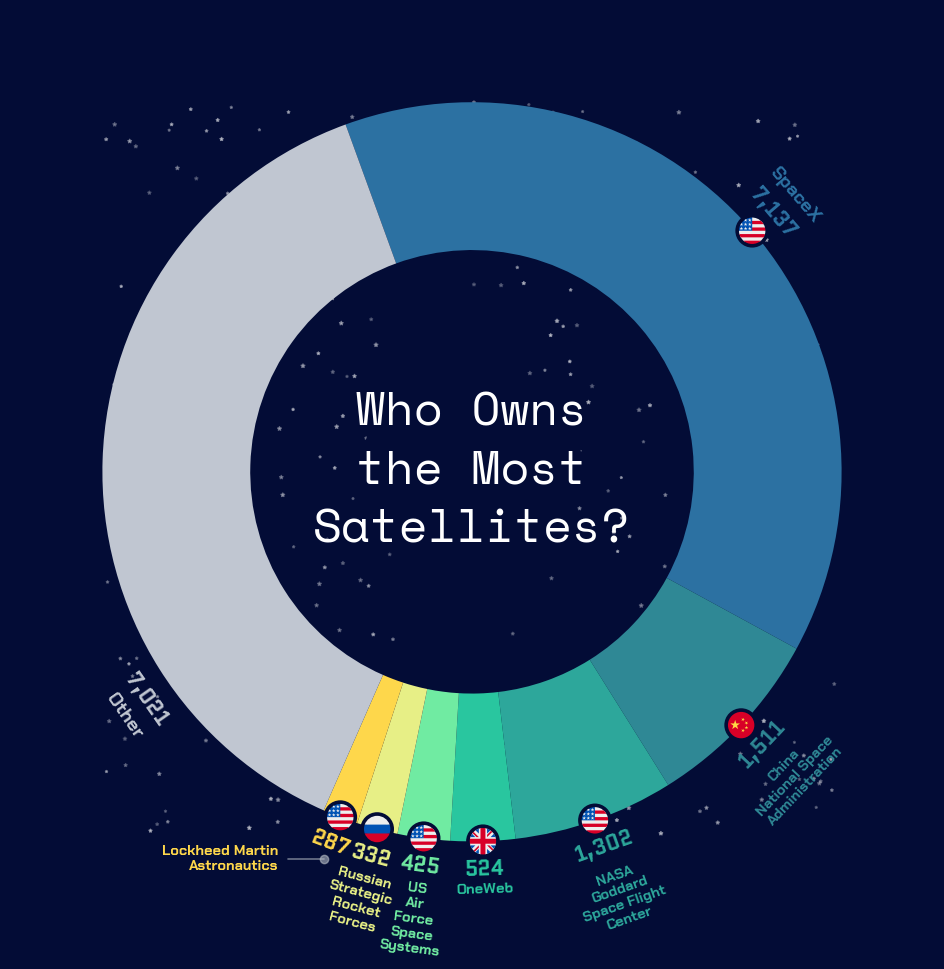

In [289]:
top_active_owners = df[df['Type'].str.contains('P', na=False) & df["Status"].isin(["O"])].groupby(['Class','ShortName', 'Name_y', 'State']).size().reset_index(name='Count').sort_values(by='Count', ascending=False)

name_replacements = {
    "SpaceX (Seattle)": "SpaceX",
    "Guojia Hangtian Ju": "China\nNational Space\nAdministration",
    "NASA Goddard Space Flight Center": "NASA\nGoddard\nSpace Flight\nCenter",
    "One Web (Network Access Associates Ltd.)": "OneWeb",
    "US Air Force Space Systems Division": "US\nAir\nForce\nSpace\nSystems",
    "Rakentiye Voiska Strategicheskogo Naznacheniye (Rossisk. Fed.)": "Russian\nStrategic\nRocket\nForces",
    "United Launch Alliance/Lockheed Martin Astronautics": "Lockheed\nMartin\nAstronautics"
}
top_active_owners["Name_y"] = top_active_owners["Name_y"].replace(name_replacements)
sorted_df = top_active_owners.sort_values(by="Count", ascending=False)
top_n_df = sorted_df.head(7)
rest_count = sorted_df.iloc[7:]["Count"].sum()
rest_of_world = pd.DataFrame([{
    "Class": "Other", "ShortName": "Other", "Name_y": "Other", "State": "", "Count": rest_count
}])

filtered_df = pd.concat([top_n_df, rest_of_world], ignore_index=True)

custom_colors = {
    "SpaceX": "#2c71a2",
    "China\nNational Space\nAdministration": "#2f8895",
    "NASA\nGoddard\nSpace Flight\nCenter": "#2da79b",
    "OneWeb": "#29c69f",
    "US\nAir\nForce\nSpace\nSystems": "#70eba2",
    "Russian\nStrategic\nRocket\nForces": "#e7ef86",
    "Lockheed\nMartin\nAstronautics": "#fed74b",
    "Other": "#C0C6D1"
}

text_adjustments = {
    "SpaceX": 1.15,
    "China\nNational Space\nAdministration": 1.2,
    "NASA\nGoddard\nSpace Flight\nCenter": 1.22,
    "OneWeb": 1.13,
    "US\nAir\nForce\nSpace\nSystems": 1.22,
    "Russian\nStrategic\nRocket\nForces": 1.2,
    "Other": 1.15
}

flag_params = {
    "US": {"size": 0.19, "distance": 1.0},
    "CN": {"size": 0.19, "distance": 1.0},
    "UK": {"size": 0.19, "distance": 1.0},
    "RU": {"size": 0.19, "distance": 1.0}
}

colors = [custom_colors[name] for name in filtered_df["Name_y"]]

start_angle = 110

fig, ax = plt.subplots(figsize=(12, 12))

def add_stars(ax, num_stars=300):
    np.random.seed(42)
    star_x = np.random.uniform(-1, 1, num_stars)
    star_y = np.random.uniform(-1, 1, num_stars)
    star_sizes = np.random.uniform(2, 8, num_stars)
    star_alpha = np.random.uniform(0.2, 0.5, num_stars)
    ax.scatter(star_x, star_y, s=star_sizes, c='white', alpha=star_alpha, marker='*')

add_stars(ax)

fig.patch.set_facecolor('#030c36')
ax.set_facecolor('#030c36')

wedges, _, _ = ax.pie(
    filtered_df["Count"], labels=None, autopct='', colors=colors, pctdistance=0.85, 
    startangle=start_angle,counterclock=False, wedgeprops={'width': 0.4}
)

for wedge, label in zip(wedges, filtered_df["Name_y"]):
    if label == "Lockheed\nMartin\nAstronautics":
        continue
        
    center_angle = (wedge.theta1 + wedge.theta2) / 2
    radius = text_adjustments.get(label, 1.0)

    if label == "Other":
        center_angle = -145
    rotation = center_angle + 90
    if label == "SpaceX":
        rotation -= 180
        
    x = radius * np.cos(np.deg2rad(center_angle))
    y = radius * np.sin(np.deg2rad(center_angle))
    
    ax.text(
        x, y, label,
        rotation=rotation,
        ha='center', va='center',
        font=chakra_bold,
        fontsize=13.5 if label == "SpaceX" or label == "Other" else 10.5,
        color=custom_colors[label]
    )

for wedge, count, org_name in zip(wedges, filtered_df["Count"], filtered_df["Name_y"]):
    center_angle = (wedge.theta1 + wedge.theta2) / 2
    radius = 1.075
    
    if org_name == "Other":
        center_angle = -145
        
    rotation = center_angle + 90
    if org_name == "SpaceX":
        rotation -= 180
        
    x = radius * np.cos(np.deg2rad(center_angle))
    y = radius * np.sin(np.deg2rad(center_angle))
    
    ax.text(
        x, y, f"{count:,}",
        rotation=rotation,
        ha='center', va='center',
        font=quan_bold,
        fontsize=15,
        color=custom_colors[org_name]
    )

flags = Flags("circle")

for wedge, state in zip(wedges, filtered_df["State"]):
    if pd.isna(state) or state == "":
        continue
        
    center_angle = (wedge.theta1 + wedge.theta2) / 2
    params = flag_params.get(state, {"size": 0.1, "distance": 1.2})
    
    x = params["distance"] * np.cos(np.deg2rad(center_angle))
    y = params["distance"] * np.sin(np.deg2rad(center_angle))
    
    outline = Circle(
        (x, y), 
        params["size"]*0.2,
        ec='#030c36', 
        fc='none', 
        lw=4, 
        alpha=1
    )
    ax.add_patch(outline)
    
    da = flags.get_drawing_area(state, wmax=params["size"]*100)
    ab = AnnotationBbox(
        da, 
        (x, y), 
        frameon=False,
        box_alignment=(0.5, 0.5)
    )
    ax.add_artist(ab)

lockheed_angle = (wedges[6].theta1 + wedges[6].theta2) / 2

dot_radius = 1.12
dot_x = dot_radius * np.cos(np.deg2rad(lockheed_angle))
dot_y = dot_radius * np.sin(np.deg2rad(lockheed_angle))

line_length = 0.1
text_x = dot_x - line_length - 0.025
text_y = dot_y


ax.plot(dot_x, dot_y, 'o', 
        markersize=6,
        color='#b4bbc3', 
        alpha=0.6)

ax.plot([dot_x - line_length, dot_x], [text_y, text_y], 
        color='#b4bbc3', 
        lw=1.2, 
        alpha=0.6, 
        solid_capstyle='round')

ax.text(text_x, text_y, "Lockheed Martin\nAstronautics",
        ha='right',
        va='center',
        font=chakra_bold,
        fontsize=10.5,
        color='#fed74b',
        linespacing=1.2)

center_circle = plt.Circle((0, 0), 0.3, fc='#030c36')

ax.text(
    0,
    0,
    "Who Owns\nthe Most\nSatellites?",
    ha='center',
    va='center',
    font=font,
    fontsize=34,
    color='white',
    linespacing=1.5
)

fig.gca().add_artist(center_circle)
...;

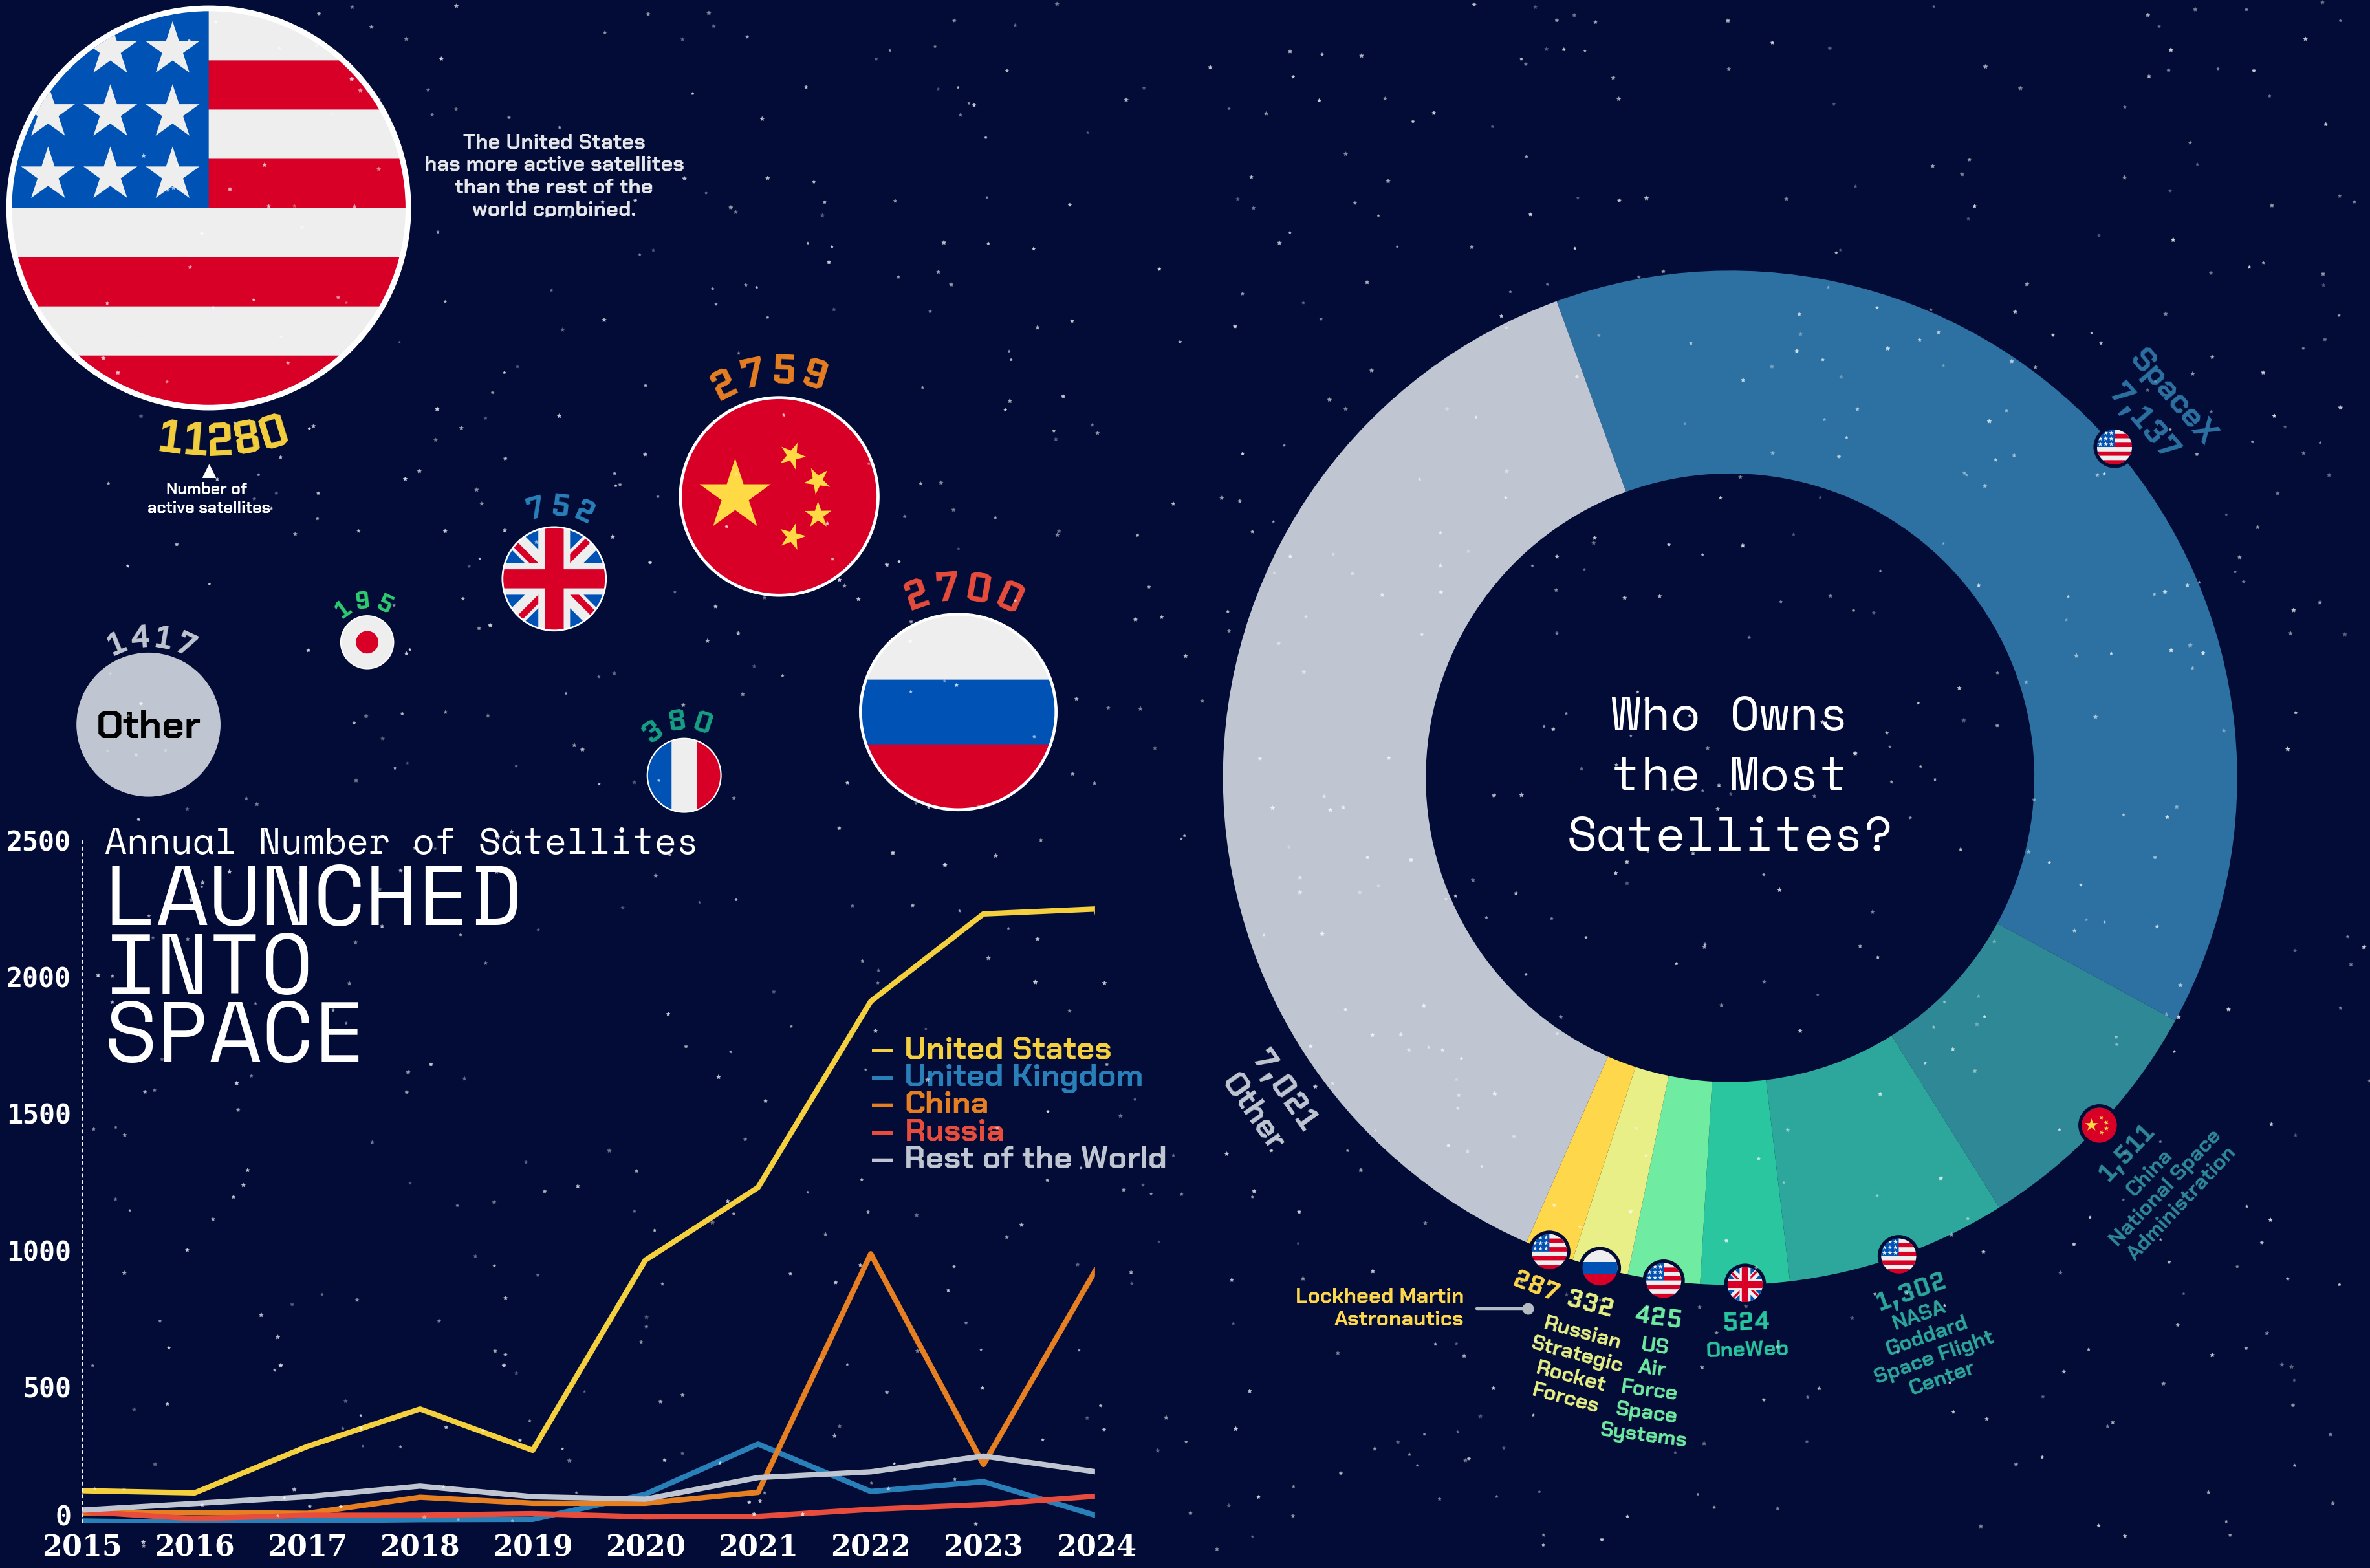

In [ ]:
fig = plt.figure(figsize=(36, 24), facecolor='#030c36')
gs = GridSpec(2, 2, figure=fig, 
              width_ratios=[12, 15], 
              height_ratios=[13, 11],
              # padding values:
              left=0.0,  
              right=0.98,  
              bottom=0.02,     
              top=0.98,        
              wspace=0, 
              hspace=0)

# Add stars to background
def add_infographic_stars(fig, num_stars=1000):
    np.random.seed(42)
    star_x = np.random.uniform(0, 1, num_stars)
    star_y = np.random.uniform(0, 1, num_stars)
    star_sizes = np.random.uniform(5, 20, num_stars)
    star_alpha = np.random.uniform(0.1, 0.4, num_stars)
    fig.patches.extend([
        plt.scatter(star_x, star_y, s=star_sizes, c='white', 
                   alpha=star_alpha, marker='*', 
                   transform=fig.transFigure, clip_on=False)
    ])


# Plot 1 (Left) - Country circles
ax1 = fig.add_subplot(gs[0, 0], facecolor='#030c36')
ax1.set_aspect('equal')

def get_circle_properties(country):
    count = top_10[country]
    radius = np.sqrt(count) * scale_factor
    return radius

def add_stars(ax, num_stars=450):
    np.random.seed(42)
    star_x = np.random.uniform(-115, 45, num_stars)
    star_y = np.random.uniform(-95, 20, num_stars)
    star_sizes = np.random.uniform(5, 20, num_stars)
    star_alpha = np.random.uniform(0.2, 0.5, num_stars)
    ax.scatter(star_x, star_y, s=star_sizes, c='white', alpha=star_alpha, marker='*')

payloads = df[df['Type'].str.contains('P', na=False) & df["Status"].isin(["O"])]
payload_counts = payloads.State.value_counts()
top_10 = payload_counts.head(10).to_dict()
other_count = payload_counts.iloc[5:].sum()
top_10["Other"] = other_count

positions = {
    "US": (-95, -1.5),
    "CN": (-5, -47),
    "RU": (23.25, -81),
    "Other": (-104.5, -83),
    "UK": (-40.5, -60),
    "F": (-20, -91),
    "J": (-70, -70),
}

colors = {
    "US": "#F4D03F",
    "CN": "#E67E22",
    "RU": "#E74C3C",
    "Other": "#C0C6D1",
    "UK": "#2980B9",
    "F": "#16A085",
    "J": "#2ECC71",
}

font_sizes = {
    "US": 51,
    "CN": 45,
    "RU": 45,
    "Other": 35,
    "UK": 34,
    "F": 33,
    "J": 27.5,
}

text_adjustments = {
    "US": 1.27,
    "CN": 1.05,
    "RU": 1.05,
    "Other": 1.0,
    "UK": 1.1,
    "F": 1.1,
    "J": 1.1,
}

labels = {
    "US": "U.S.A.",
    "CN": "China",
    "RU": "Russia",
    "Other": "Other",
    "UK": "U.K.",
    "F": "France",
    "J": "Japan",
}

scale_factor = 0.3

ax1.set_xlim(-115, 45)
ax1.set_ylim(-95, 20)
ax1.set_frame_on(False)
ax1.set_xticks([])
ax1.set_yticks([])


#add_stars(ax1)

flags = Flags("circle")

for country, (x, y) in positions.items():
    radius = get_circle_properties(country)
    
    # Create white circular background
    circle = patches.Circle((x, y), radius,
                            color='#C0C6D1' if country == 'Other' else 'white',
                            alpha=1,
                            clip_on=False)
    ax1.add_patch(circle)
    
    if country == "UK":
        country_code = "GB"
    elif country == "F":
        country_code = "FR"
    elif country == "J":
        country_code = "JP"
    elif country == "Other":
        pass 
    else:
        country_code = country
    
    if country != "Other":
        da = flags.get_drawing_area(country_code, wmax=radius*13.75)
        ab = AnnotationBbox(da, (x, y), frameon=False, box_alignment=(0.5, 0.5))
        ax1.add_artist(ab)
    
    if country == "F" or country == "J":
        theta = np.linspace(3 * np.pi / 2, 3 * np.pi / 2 + 2 * np.pi, 100)
    else:
        theta = np.linspace(0, 2 * np.pi, 100)
    
    if country in ["US"]:
        text_x = x - (radius * text_adjustments[country]) * np.cos(theta)
        text_y = y - (radius * text_adjustments[country]) * np.sin(theta)
    else:
        text_x = x + (radius * text_adjustments[country]) * -np.cos(theta)
        text_y = y + (radius * text_adjustments[country]) * np.sin(theta)

    
    font_color = colors[country]

    if country == 'US':
        padding = " " * 63
    elif country == 'CN':
        padding = " " * 18
    elif country == 'RU':
        padding = " " * 20
    elif country == 'F':
        padding = " " * 16
    elif country == 'J':
        padding = " " * 11
    elif country == 'Other':
        padding = " " * 13
    else:
        padding = " " * 11
    
    CurvedText(
        x=text_x,
        y=text_y,
        text=padding + f"{top_10[country]}",
        va="bottom",
        axes=ax1,
        fontsize=font_sizes[country],
        font=quan_bold,
        fontweight="bold",
        color=font_color
    )

ax1.text(-104.5, -85, "Other", ha='center', font=chakra_bold, fontsize=43)
ax1.text(-40.5, -2.65, "The United States\nhas more active satellites\nthan the rest of the\nworld combined.", ha='center', color='white', font=chakra_bold, fontsize=23.5, alpha=0.9);
ax1.scatter(-95, -43, marker='^', s=200, color='white')
ax1.text(-95, -49.5, "Number of \nactive satellites", ha='center', color='white', font=chakra_bold, fontsize=18, alpha=1)

# plot 2
df_copy = df.copy()

df_copy["Launch_Year"] = pd.to_datetime(df_copy["LDate"], errors="coerce").dt.year
df_copy = df_copy[df_copy['Type'].str.contains('P', na=False)]
df_copy = df_copy[["Launch_Year", "State"]].dropna()

top_countries = {"US": "United States",
                 "CN": "China",
                 "RU": "Russia",
                 "UK": "United Kingdom"}

df_copy["Country"] = df_copy["State"].map(top_countries).fillna("Other")
launch_counts = df_copy.groupby(["Launch_Year", "Country"]).size().unstack(fill_value=0)

ax2 = fig.add_subplot(gs[1, 0], facecolor='#030c36')

colors = {
    "United States": "#F4D03F",
    "China": "#E67E22",
    "Russia": "#E74C3C",
    "United Kingdom": "#2980B9",
    "Other": "#C0C6D1"
}

order = ['United States', 'United Kingdom', "China", "Russia", "Other"]

for country in order:
    if country in launch_counts.columns:
        ax2.plot(launch_counts.index, launch_counts[country], 
                label=country, color=colors[country], linewidth=6)

ax2.axvline(2024, color="#030c36", linewidth=3.75)

plt.rcParams['font.family'] = 'serif'

def add_stars(ax, num_stars=300):
    for _ in range(num_stars):
        x = np.random.random()
        y = np.random.random()
        size = np.random.uniform(5, 20)
        alpha = np.random.uniform(0.3, 0.7)
        ax.scatter(x, y, color='white', s=size, alpha=alpha, 
                  transform=ax.transAxes, clip_on=False, marker='*')

#add_stars(ax2)

ax2.set_xticks(range(2015, 2026))
ax2.set_xlim(2015, 2024)
ax2.set_ylim(0, 2500)


for spine in ['bottom', 'left']:
    ax2.spines[spine].set_linestyle((0, (5, 5)))
    ax2.spines[spine].set_linewidth(0.7)
    ax2.spines[spine].set_color('white')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax2.tick_params(axis='both', which='both', length=0)

ax2.tick_params(axis='x', labelsize=24, colors='white')
for label in ax2.get_xticklabels():
    label.set_size(32)
    label.set_fontfamily('serif')
    label.set_fontweight('bold')

ax2.set_xticks([x for x in range(2015, 2025)])

ax2.tick_params(axis='y', labelsize=30, colors='white')

current_yticks = ax2.get_yticks()
new_yticks = [tick for tick in current_yticks if tick != 0]
new_yticks.append(30)
new_yticks = sorted(new_yticks)
ax2.set_yticks(new_yticks)
custom_ylabels = [str(int(tick)) if tick != 30 else '0' for tick in new_yticks]
ax2.set_yticklabels(custom_ylabels)

for label in ax2.get_yticklabels():
    label.set_fontweight('bold')
    label.set_fontfamily('monospace')

ax2.xaxis.set_tick_params(pad=12)
ax2.yaxis.set_tick_params(pad=12)

ax2.tick_params(axis='both', which='both', length=0)
ax2.text(2015.2, 2450, 'Annual Number of Satellites', font=font, fontsize=40, color='white')
ax2.text(2015.2, 2190, 'LAUNCHED', font=font, fontsize=95, color='white')
ax2.text(2015.2, 1940, 'INTO', font=font, fontsize=95, color='white')
ax2.text(2015.2, 1690, 'SPACE', font=font, fontsize=95, color='white')

ax2.text(2022, 1700, '—', font=chakra_bold, fontsize=35, color='#F4D03F')
ax2.text(2022.3, 1700, 'United States', font=chakra_bold, fontsize=35, color='#F4D03F')

ax2.text(2022, 1600, '—', font=chakra_bold, fontsize=35, color='#2980B9')
ax2.text(2022.3, 1600, 'United Kingdom', font=chakra_bold, fontsize=35, color='#2980B9')

ax2.text(2022, 1500, '—', font=chakra_bold, fontsize=35, color='#E67E22')
ax2.text(2022.3, 1500, 'China', font=chakra_bold, fontsize=35, color='#E67E22')

ax2.text(2022, 1400, '—', font=chakra_bold, fontsize=35, color='#E74C3C')
ax2.text(2022.3, 1400, 'Russia', font=chakra_bold, fontsize=35, color='#E74C3C')

ax2.text(2022, 1300, '—', font=chakra_bold, fontsize=35, color='#C0C6D1')
ax2.text(2022.3, 1300, 'Rest of the World', font=chakra_bold, fontsize=35, color='#C0C6D1')


ax3 = fig.add_subplot(gs[:, 1], facecolor='#030c36') 
ax3.set_aspect('equal')
top_active_owners = df[df['Type'].str.contains('P', na=False) & df["Status"].isin(["O"])].groupby(['Class','ShortName', 'Name_y', 'State']).size().reset_index(name='Count').sort_values(by='Count', ascending=False)

name_replacements = {
    "SpaceX (Seattle)": "SpaceX",
    "Guojia Hangtian Ju": "China\nNational Space\nAdministration",
    "NASA Goddard Space Flight Center": "NASA\nGoddard\nSpace Flight\nCenter",
    "One Web (Network Access Associates Ltd.)": "OneWeb",
    "US Air Force Space Systems Division": "US\nAir\nForce\nSpace\nSystems",
    "Rakentiye Voiska Strategicheskogo Naznacheniye (Rossisk. Fed.)": "Russian\nStrategic\nRocket\nForces",
    "United Launch Alliance/Lockheed Martin Astronautics": "Lockheed\nMartin\nAstronautics"
}
top_active_owners["Name_y"] = top_active_owners["Name_y"].replace(name_replacements)
sorted_df = top_active_owners.sort_values(by="Count", ascending=False)
top_n_df = sorted_df.head(7)
rest_count = sorted_df.iloc[7:]["Count"].sum()
rest_of_world = pd.DataFrame([{
    "Class": "Other", "ShortName": "Other", "Name_y": "Other", "State": "", "Count": rest_count
}])

filtered_df = pd.concat([top_n_df, rest_of_world], ignore_index=True)

custom_colors = {
    "SpaceX": "#2c71a2",
    "China\nNational Space\nAdministration": "#2f8895",
    "NASA\nGoddard\nSpace Flight\nCenter": "#2da79b",
    "OneWeb": "#29c69f",
    "US\nAir\nForce\nSpace\nSystems": "#70eba2",
    "Russian\nStrategic\nRocket\nForces": "#e7ef86",
    "Lockheed\nMartin\nAstronautics": "#fed74b",
    "Other": "#C0C6D1"
}

text_adjustments = {
    "SpaceX": 1.15,
    "China\nNational Space\nAdministration": 1.18,
    "NASA\nGoddard\nSpace Flight\nCenter": 1.19,
    "OneWeb": 1.13,
    "US\nAir\nForce\nSpace\nSystems": 1.22,
    "Russian\nStrategic\nRocket\nForces": 1.2,
    "Other": 1.15
}

flag_params = {
    "US": {"size": 0.19, "distance": 1.0},
    "CN": {"size": 0.19, "distance": 1.0},
    "UK": {"size": 0.19, "distance": 1.0},
    "RU": {"size": 0.19, "distance": 1.0}
}

colors = [custom_colors[name] for name in filtered_df["Name_y"]]

start_angle = 110

def add_stars(ax, num_stars=600):
    np.random.seed(42)
    star_x = np.random.uniform(-1, 1, num_stars)
    star_y = np.random.uniform(-1, 1, num_stars)
    star_sizes = np.random.uniform(5, 20, num_stars)
    star_alpha = np.random.uniform(0.2, 0.5, num_stars)
    ax.scatter(star_x, star_y, s=star_sizes, c='white', alpha=star_alpha, marker='*')

#add_stars(ax3)

wedges, _, _ = ax3.pie(
    filtered_df["Count"], labels=None, autopct='', colors=colors, pctdistance=0.85, 
    startangle=start_angle,counterclock=False, wedgeprops={'width': 0.4}
)

for wedge, label in zip(wedges, filtered_df["Name_y"]):
    if label == "Lockheed\nMartin\nAstronautics":
        continue
        
    center_angle = (wedge.theta1 + wedge.theta2) / 2
    radius = text_adjustments.get(label, 1.0)

    if label == "Other":
        center_angle = -145
    rotation = center_angle + 90
    if label == "SpaceX":
        rotation -= 180
        
    x = radius * np.cos(np.deg2rad(center_angle))
    y = radius * np.sin(np.deg2rad(center_angle))
    
    ax3.text(
        x, y, label,
        rotation=rotation,
        ha='center', va='center',
        font=chakra_bold,
        fontsize=35.5 if label == "SpaceX" or label == "Other" else 23.5,
        color=custom_colors[label]
    )

for wedge, count, org_name in zip(wedges, filtered_df["Count"], filtered_df["Name_y"]):
    center_angle = (wedge.theta1 + wedge.theta2) / 2
    radius = 1.075
    
    if org_name == "Other":
        center_angle = -145
        
    rotation = center_angle + 90
    if org_name == "SpaceX":
        rotation -= 180
        
    x = radius * np.cos(np.deg2rad(center_angle))
    y = radius * np.sin(np.deg2rad(center_angle))
    
    ax3.text(
        x, y, f"{count:,}",
        rotation=rotation,
        ha='center', va='center',
        font=quan_bold,
        fontsize=35.5 if org_name == "SpaceX" or org_name == "Other" else 28,
        color=custom_colors[org_name]
    )

flags = Flags("circle")

for wedge, state in zip(wedges, filtered_df["State"]):
    if pd.isna(state) or state == "":
        continue
        
    center_angle = (wedge.theta1 + wedge.theta2) / 2
    params = flag_params.get(state, {"size": 0.1, "distance": 1.2})
    
    x = params["distance"] * np.cos(np.deg2rad(center_angle))
    y = params["distance"] * np.sin(np.deg2rad(center_angle))
    
    outline = Circle(
        (x, y), 
        params["size"]*0.2,
        ec='#030c36', 
        fc='none', 
        lw=4, 
        alpha=1
    )
    ax3.add_patch(outline)
    
    da = flags.get_drawing_area(state, wmax=params["size"]*205)
    ab = AnnotationBbox(
        da, 
        (x, y), 
        frameon=False,
        box_alignment=(0.5, 0.5)
    )
    ax3.add_artist(ab)

lockheed_angle = (wedges[6].theta1 + wedges[6].theta2) / 2

dot_radius = 1.12
dot_x = dot_radius * np.cos(np.deg2rad(lockheed_angle))
dot_y = dot_radius * np.sin(np.deg2rad(lockheed_angle))

line_length = 0.1
text_x = dot_x - line_length - 0.025
text_y = dot_y


ax3.plot(dot_x, dot_y, 'o', 
        markersize=12,
        color='#b4bbc3', 
        alpha=1)

ax3.plot([dot_x - line_length, dot_x], [text_y, text_y], 
        color='#b4bbc3', 
        lw=3.2, 
        alpha=1, 
        solid_capstyle='round')

ax3.text(text_x, text_y, "Lockheed Martin\nAstronautics",
        ha='right',
        va='center',
        font=chakra_bold,
        fontsize=23.5,
        color='#fed74b',
        linespacing=1.2)

center_circle = plt.Circle((0, 0), 0.3, fc='#030c36')

ax3.text(
    0,
    0,
    "Who Owns\nthe Most\nSatellites?",
    ha='center',
    va='center',
    font=font,
    fontsize=54,
    color='white',
    linespacing=1.5
)

fig.gca().add_artist(center_circle)

#fig.patch.set_edgecolor('black')  # Border color (e.g., black, red, etc.)
#fig.patch.set_linewidth(5)        # Border thickness (e.g., 5 pixels)
#fig.patch.set_visible(True)       # Ensure the background patch is visible
add_infographic_stars(fig)
plt.savefig('satellite_infographic.png', dpi=300, bbox_inches='tight')